---
title: |
  \normalsize Course M-GFP3: Imaging and non-imaging spectroscopy:\
  Term Paper
subtitle:
  \Large Strategies to enhance predictive modeling of soil organic carbon (SOC) using the LUCAS topsoil spectral library.

author: "Deepak, Khuzaima, Luis"
date: "February 20, 2025"

# Formatting
format:
  pdf:
    documentclass: scrartcl
    papersize: letter
    toc: true
    toc-depth: 3
    number-sections: true
    colorlinrandom: true
    linkcolor: blue
    urlcolor: blue
    citecolor: blue
    
    geometry:
      - margin=1in
    highlight-style: gruvbox
    code-block-background: true
    code-fold: true
    code-overflow: scroll
    fig-pos: "H"
    include-in-header: 
      text: |
        \usepackage{tcolorbox}
        \usepackage{float}
        \usepackage{booktabs}
        \usepackage{longtable}
        \tcbuselibrary{skins,breakable}

# Execution options
execute:
  echo: true
  warning: false
  message: false
  cache: true

# Bibliography if needed
#bibliography: references.bib
---

# Packages

In [1]:
# Use autoreload to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import own_functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import geopandas as gpd
from autogluon.tabular import TabularDataset, TabularPredictor


In [4]:
import autogluon 

# Data

Data splitting (5 P):

- Split your data into a calibration data set (~70%) and an independent test data set (~30%). 
- Show that both are representative of the full data set.
-  For procedures with randomized approaches, please define and note the seed (in R: set.seed( ) ) to make the split reproducible for the instructors. 
- From this point onward, the composition of the test data set must remain constant and unchanged for all subsequent tasks

## Load and Clean

In [5]:
# Load data
data = pd.read_csv('data/France_spc.csv')

# Remove unnecessary column
data = data.drop(columns=['Unnamed: 0'])

print(f"Data rows: {data.shape[0]}, columns: {data.shape[1]}")
display(data.head())

Data rows: 2807, columns: 1000


,500,502,504,506,508,510,512,514,516,518,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,0.137399,0.139045,0.140758,0.142544,0.144388,0.146281,0.148221,0.150205,0.152239,0.154322,...,0.380845,0.379886,0.378946,0.378047,0.377186,0.376361,0.375612,0.374935,0.374315,0.373759
1,0.141740,0.142851,0.144007,0.145208,0.146450,0.147726,0.149025,0.150348,0.151702,0.153081,...,0.261258,0.260330,0.259418,0.258505,0.257603,0.256744,0.255934,0.255173,0.254467,0.253815
2,0.140713,0.142216,0.143778,0.145392,0.147053,0.148756,0.150488,0.152257,0.154059,0.155892,...,0.402253,0.401367,0.400499,0.399693,0.398964,0.398307,0.397749,0.397298,0.396927,0.396609
3,0.128922,0.129908,0.130919,0.131959,0.133019,0.134102,0.135196,0.136307,0.137433,0.138571,...,0.331686,0.331122,0.330591,0.330075,0.329612,0.329210,0.328841,0.328509,0.328244,0.328046
4,0.161760,0.163229,0.164741,0.166298,0.167895,0.169530,0.171194,0.172890,0.174611,0.176356,...,0.404026,0.403154,0.402350,0.401604,0.400916,0.400319,0.399808,0.399354,0.398933,0.398586


In [6]:
target_raw = pd.read_csv('data/France_lab.csv')
lat_lon = target_raw[['GPS_LAT', 'GPS_LONG']]
target = target_raw['SOC']
print(f"Target rows: {target.shape[0]}")

Target rows: 2807


In [7]:
target_raw

,Unnamed: 0,SAMPLE_ID,CLAY,SILT,SAND,SOC,CaCO3,N,P,K,CEC,GPS_PROJ,GPS_LAT,GPS_LONG,LC1,LC2,LU1,LU2,MINERAL,COUNTRY
0,1,10000,40.0,52.0,8.0,15.6,1,1.4,42.6,491.1,24.6,WGS84,45.893933,4.680379,B82,E10,U111,8,mineral,FRANCE
1,2,10001,26.0,18.0,56.0,19.8,1,1.6,19.5,279.1,20.6,WGS84,45.816720,4.584692,E10,8,U370,8,mineral,FRANCE
2,3,10002,22.0,41.0,37.0,33.5,1,2.6,37.8,399.1,15.0,WGS84,45.983716,4.671533,E10,8,U111,8,mineral,FRANCE
3,4,10004,27.0,47.0,26.0,66.1,21,6.6,147.7,1080.6,30.5,WGS84,45.908022,4.601575,E10,8,U111,8,mineral,FRANCE
4,5,10005,16.0,32.0,52.0,38.1,0,2.6,49.6,293.9,7.8,WGS84,46.082345,4.480490,E20,8,U111,8,mineral,FRANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,2803,9994,19.0,62.0,19.0,9.1,0,1.2,44.5,131.8,9.7,WGS84,45.615242,4.887293,B31,8,U111,8,mineral,FRANCE
2803,2804,9995,16.0,41.0,42.0,13.4,0,1.4,33.0,184.4,7.2,WGS84,45.713629,5.058028,B16,8,U111,8,mineral,FRANCE
2804,2805,9996,13.0,29.0,58.0,8.7,3,1.3,104.9,425.4,7.7,WGS84,45.767539,5.053155,B16,8,U111,8,mineral,FRANCE
2805,2806,9997,20.0,38.0,42.0,30.6,0,3.0,56.1,107.8,12.6,WGS84,45.788303,4.381513,E20,8,U111,8,mineral,FRANCE


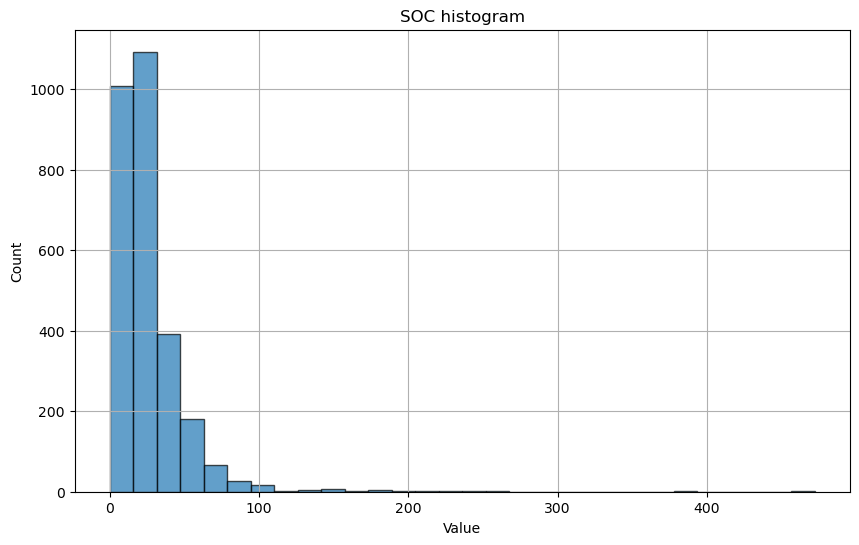

In [8]:
# plot soc histogram
plt.figure(figsize=(10, 6))
plt.hist(target, bins=30, edgecolor='k', alpha=0.7)
plt.title('SOC histogram')
plt.xlabel('Value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

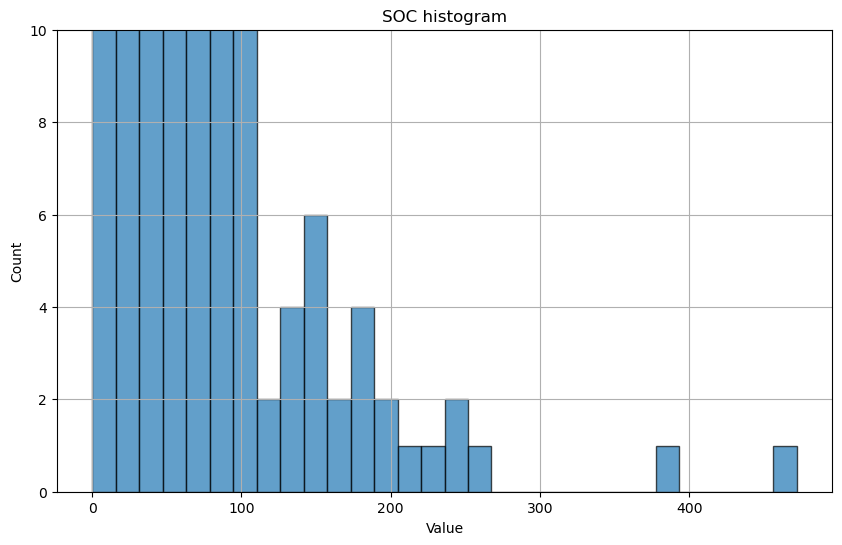

In [9]:
# plot soc histogram
plt.figure(figsize=(10, 6))
plt.hist(target, bins=30, edgecolor='k', alpha=0.7)
plt.title('SOC histogram')
plt.xlabel('Value')
plt.ylabel('Count')
plt.ylim((0,10))
plt.grid(True)
plt.show()

## Sampling and Splitting

In [10]:
# Extract features and target as numpy array
X = data.values
y = target.values

In [274]:
### Sampling strategies
# Step 1: Generate or Load Data
np.random.seed(100)  # Set seed for reproducibility

# Step 2: Random Split (70% Calibration, 30% Test)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.3, random_state=100)

print(f"Random Split: {X_train_random.shape[0]} training samples, {X_test_random.shape[0]} test samples")

# Step 3: Apply Kennard-Stone to select 70% of the data
n_train = int(0.7 * X.shape[0])

# Get indices
ks_indices = own_functions.kennard_stone(X, n_train)

# Select Training data
X_train_ks = X[ks_indices,:]
y_train_ks = y[ks_indices]

# Select Test
test_indices = np.setdiff1d(np.arange(X.shape[0]), ks_indices)
X_test_ks = X[test_indices]
y_test_ks = y[test_indices]

print(f"Kennard-Stone: {X_train_ks.shape[0]} training samples, {X_test_ks.shape[0]} test samples")

# Step 4: PCA for Visualization
pca = PCA(n_components=2)

# Fit PCA on full data
X_pca = pca.fit_transform(X)  

# Transform data
X_train_random_pca = pca.transform(X_train_random)  # PCA on random calibration set
X_test_random_pca = pca.transform(X_test_random)  # PCA on random test set
X_cal_ks_pca = pca.transform(X_train_ks)  # PCA on Kennard-Stone calibration set
X_test_ks_pca = pca.transform(X_test_ks)  # PCA on Kennard-Stone test set

Random Split: 1964 training samples, 843 test samples
Kennard-Stone: 1964 training samples, 843 test samples


In [12]:
#TODO: Show that both test and train are representative of the full dataset

Random Split:
Train set shape: (1964, 1000)
Test set shape: (843, 1000)

Kennard-Stone Split:
Train set shape: (1964, 1000)
Test set shape: (843, 1000)


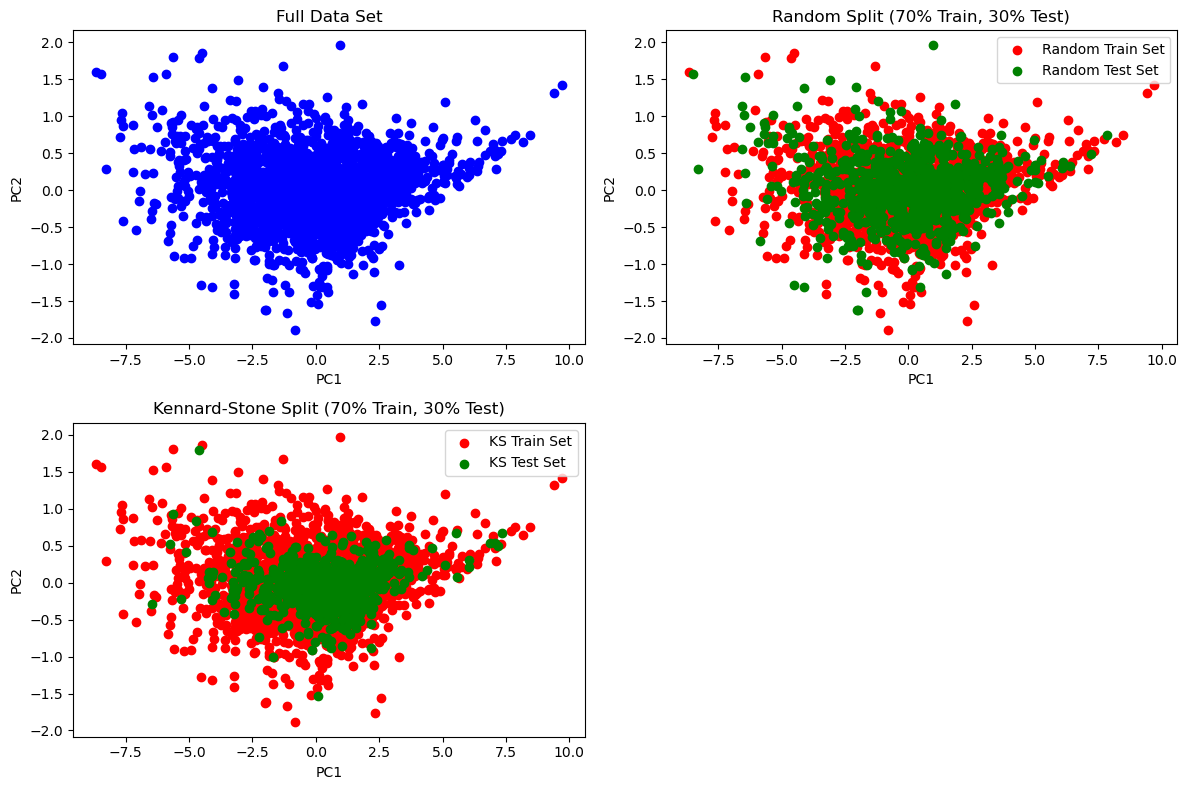

In [13]:
# Step 5: Plot Results
own_functions.plot_pca_comparison(X_full=X,
                                  X_train_random=X_train_random,
                                  X_test_random=X_test_random,
                                  X_train_ks=X_train_ks,
                                  X_test_ks=X_test_ks)

In [14]:
X_train = X_train_ks
y_train = y_train_ks

X_test = X_test_ks
y_test = y_test_ks

# Basemodel

Baseline model (5 P):
- Develop a global baseline PLSR model using the *calibration dataset* 
  - (entire VNIR range from 500 nm to 2499 nm in steps of 2 nm) 
  - *without* applying any *spectral* *preprocessing*. 
- The target variable is soil organic carbon (SOC). 
- Perform *internal optimization* to *determine* the *optimal* *number* of *latent* *PLS* *variables* 
  -  *report your selected value*. 
- Apply the optimized model* to the independent test set*. 
  - Compute the validation metrics *(R², RMSE, bias, and RPD)*
  - *visualize* the results in a *scatter* *plot* (observed vs. predicted values) 
  - and assess the model's performance.

## Finding optimal number of commponents

In [15]:
import own_functions

Rough Optimization:   0%|          | 0/7 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

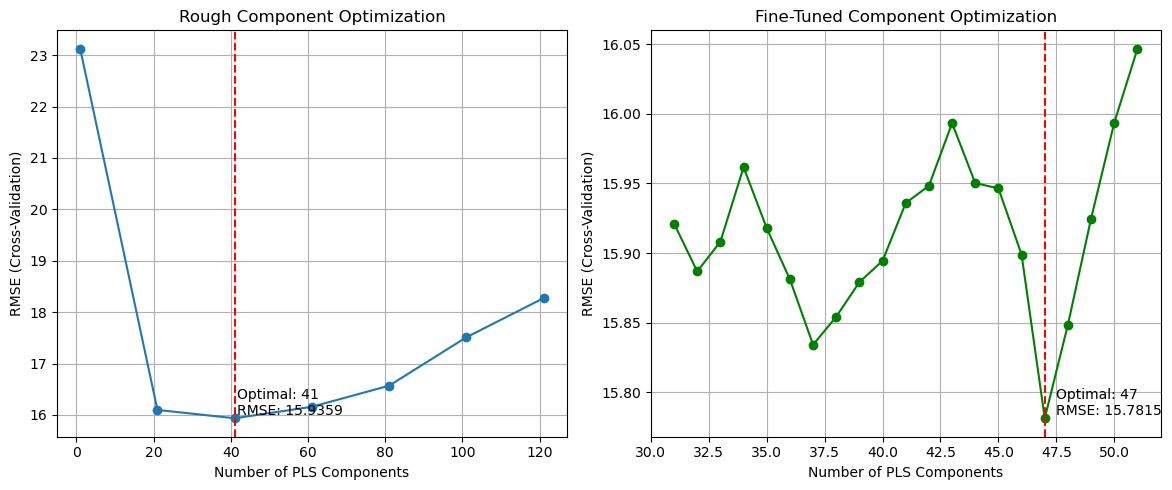

In [16]:
plsr_base_components = own_functions.optimize_pls_components(X_train=X_train, 
                                      y_train=y_train,
                                      max_components=140,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )

## Evaluating Base Model

Root Mean Squared Error (RMSE): 10.0547
R²: 0.6552
Bias: -0.1772
RPD: 1.7030


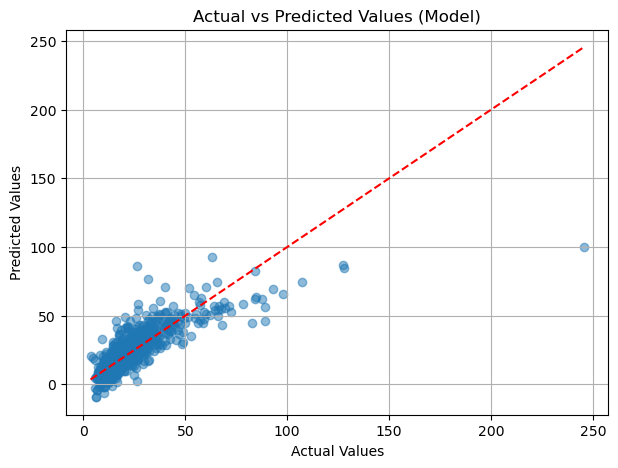

In [17]:
plsr_base_model = PLSRegression(n_components=plsr_base_components["optimal_n"])
plsr_base_model.fit(X_train, y_train)

plsr_base_eval = own_functions.evaluate_model(plsr_base_model,
                             X_test=X_test,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True
                             )

# Model Improvement Strategies (5 P per strategy):
- Develop and evaluate three distinct strategies to improve the baseline model, 
  - using the **same independent test set for validation**. 
- For each strategy, report the validation metrics
    - (R², RMSE, bias, and RPD), 
    - visualize the best result in a scatter plot (observed vs.predicted values) 
    - assess the performance of these alternative models. 
    - Use the same independent test set for all strategies to ensure that validation metrics are directly comparable.


IMPORTANT: Testing two or more spectral preprocessing methods is considered one
strategy, not multiple strategies. Similarly, testing one or more alternative regression
algorithms counts as one strategy, not multiple.

## Varying Preprocessing Strategy

### Savitzgy-Golay

In [18]:
#TODO: Is scaling necessary? - Does not seem to make a difference -> removed

# Applying Savitzky-Golay filter to calibration and test data
X_train_sg = own_functions.apply_savitzky_golay(X_train, window_length=31, polyorder=4, deriv=0, delta=2)
X_test_sg = own_functions.apply_savitzky_golay(X_test, window_length=31, polyorder=4, deriv=0, delta=2)

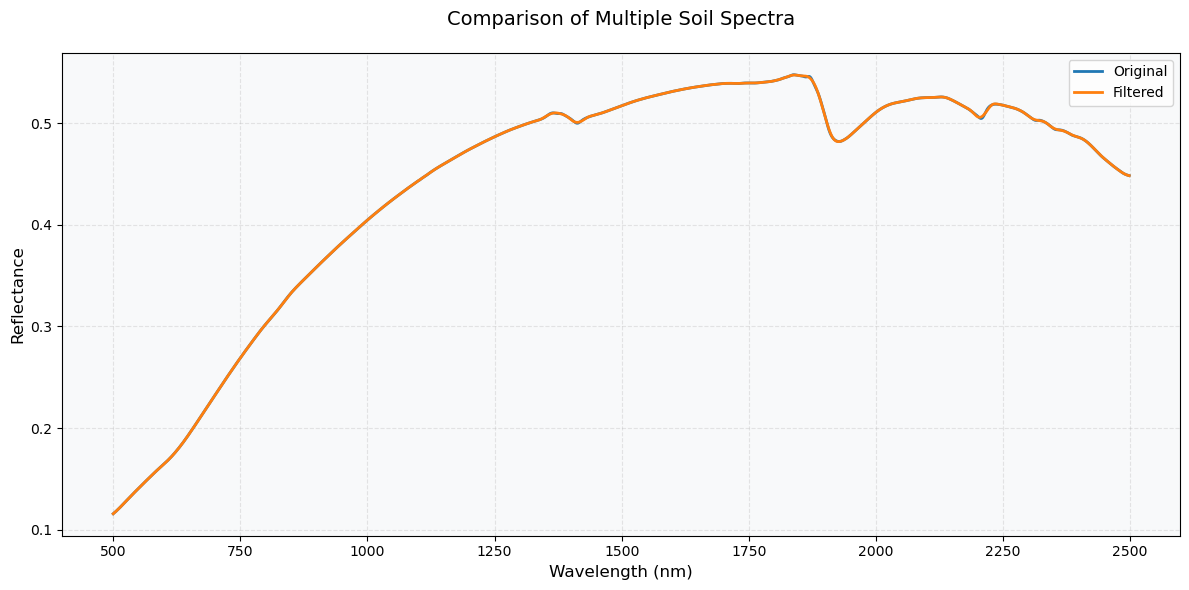

In [ ]:
own_functions.plot_spectra_comparison(
    X_train[2],
    X_train_sg[2],
    wavelengths=range(500, 2500, 2),
    labels=['Original', 'Filtered'],
    title='Comparison of Multiple Soil Spectra'
)

Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

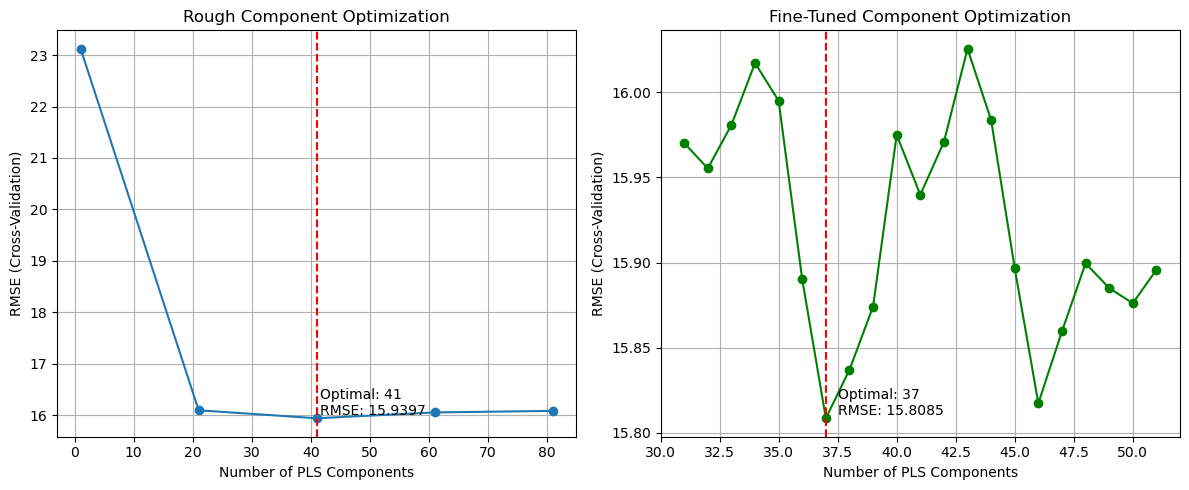

In [20]:
plsr_sgolay_components = own_functions.optimize_pls_components(X_train=X_train_sg, 
                                      y_train=y_train,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )

Root Mean Squared Error (RMSE): 10.1694
R²: 0.6473
Bias: -0.1207
RPD: 1.6838


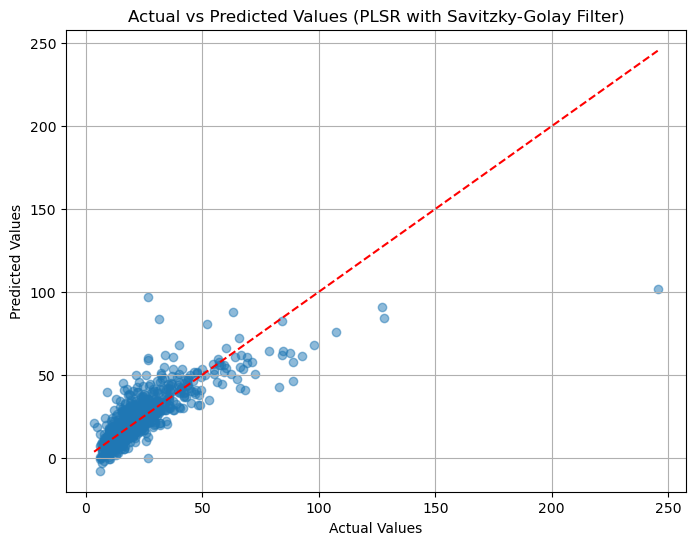

In [21]:
plsr_sg_model = PLSRegression(n_components=plsr_sgolay_components["optimal_n"])
plsr_sg_model.fit(X_train_sg, y_train)

plsr_sg_eval = own_functions.evaluate_model(plsr_sg_model,
                             X_test=X_test_sg,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with Savitzky-Golay Filter',
                                          'figsize': (8, 6)}
                             )

### Standard Normal Variate

In [22]:
import own_functions

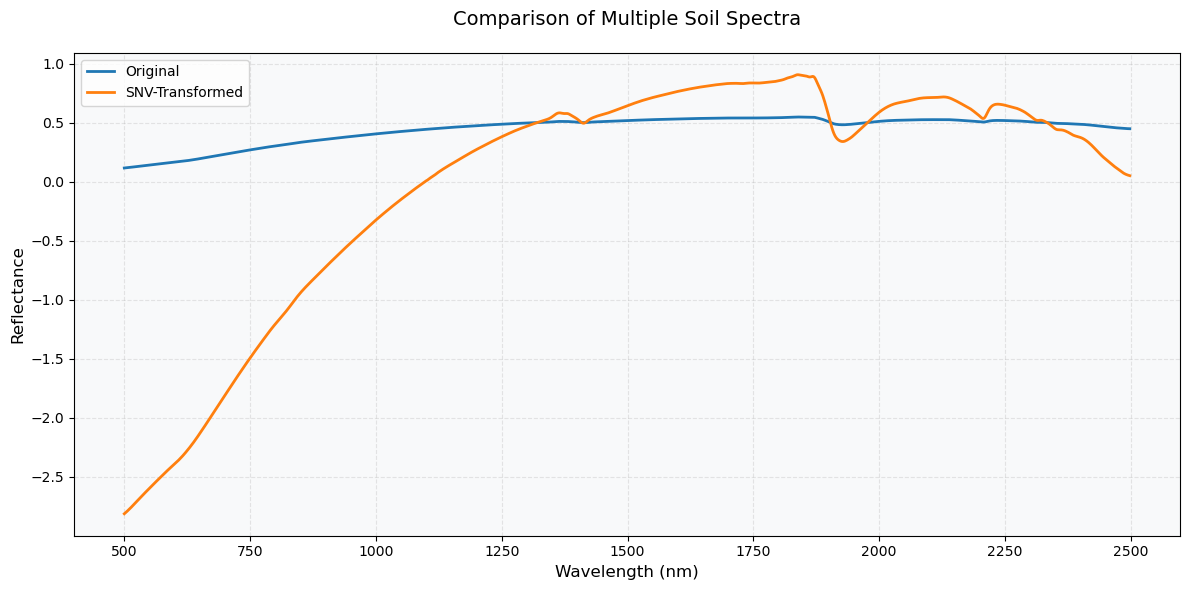

Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

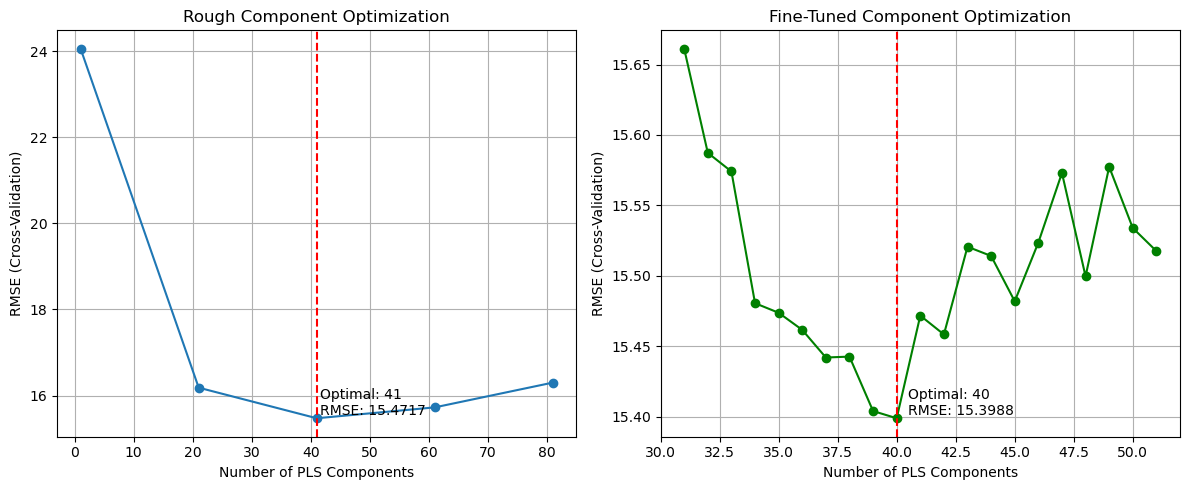

Root Mean Squared Error (RMSE): 10.1517
R²: 0.6485
Bias: 0.3009
RPD: 1.6867


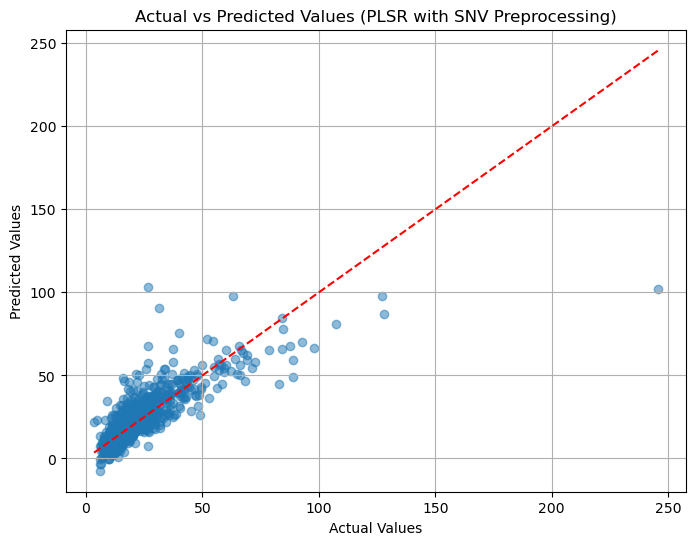

In [ ]:
# Applying Savitzky-Golay filter to calibration and test data
X_train_snv = own_functions.standard_normal_variate(X_train)
X_test_snv = own_functions.standard_normal_variate(X_test)

# Example usage with multiple spectra:
own_functions.plot_spectra_comparison(
    X_train[2],
    X_train_snv[2],
    wavelengths=range(500, 2500, 2),
    labels=['Original', 'SNV-Transformed'],
    title='Comparison of Multiple Soil Spectra'
)

plsr_snv_components = own_functions.optimize_pls_components(X_train=X_train_snv, 
                                      y_train=y_train,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )

plsr_snv_model = PLSRegression(n_components=plsr_snv_components["optimal_n"])
plsr_snv_model.fit(X_train_snv, y_train)

plsr_snv_eval = own_functions.evaluate_model(plsr_snv_model,
                             X_test=X_test_snv,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with SNV Preprocessing',
                             'figsize': (8, 6)}
                             )

### Absorbance

In [24]:
# Calculate pseudo abosrbance
X_train_absorb = np.log10(1/X_train)
X_test_absorb = np.log10(1/X_test)

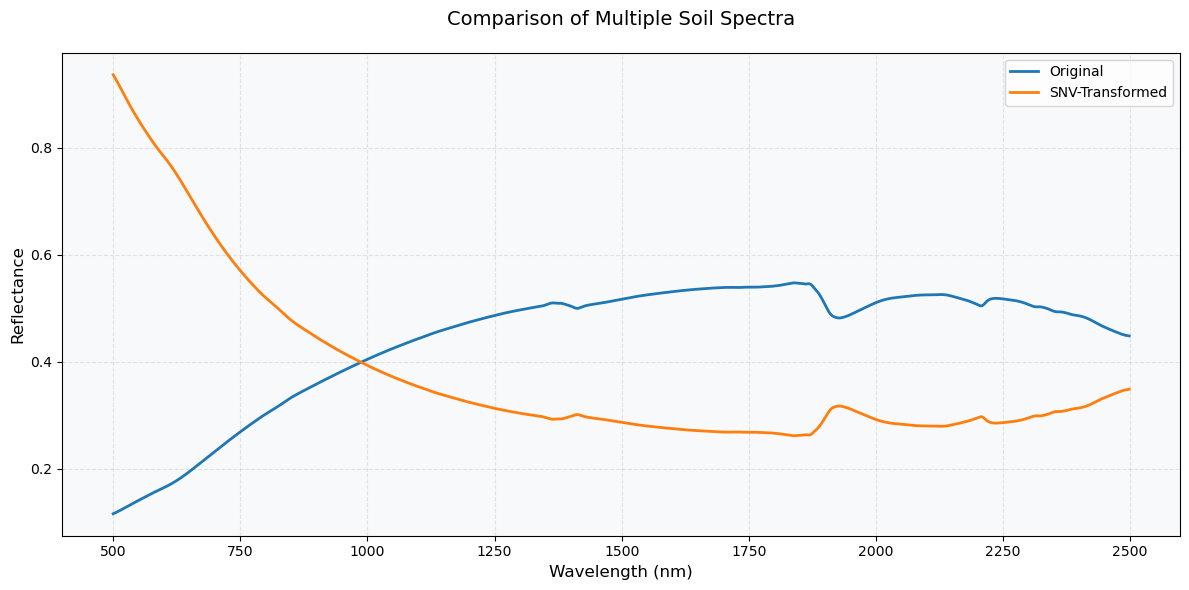

Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

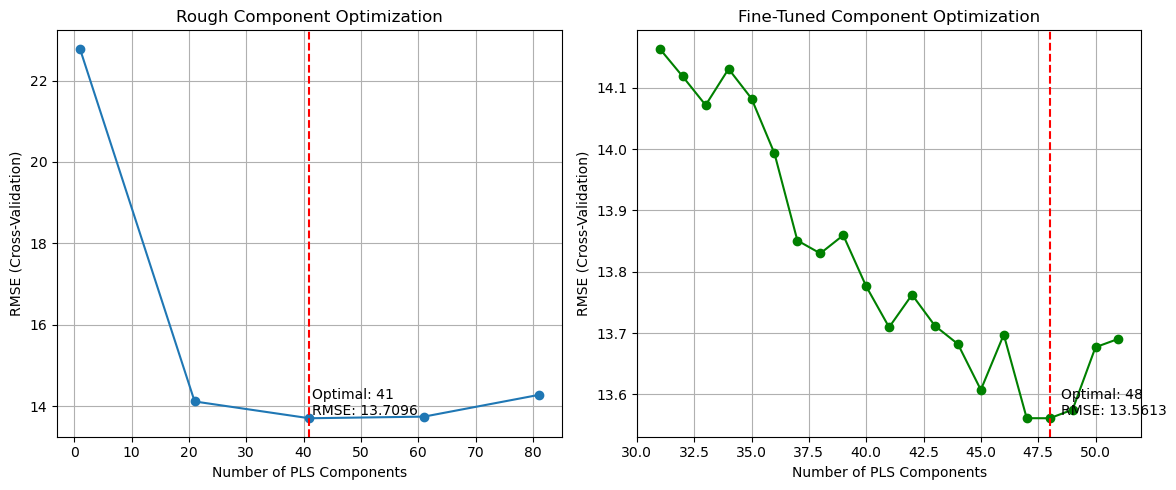

Root Mean Squared Error (RMSE): 8.6069
R²: 0.7474
Bias: 0.1506
RPD: 1.9895


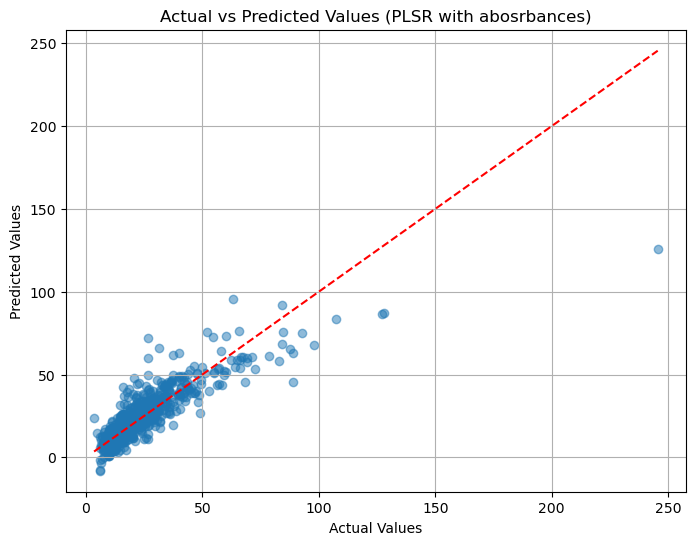

In [ ]:
# Plot Spectra
own_functions.plot_spectra_comparison(
    X_train[2],
    X_train_absorb[2],
    wavelengths=range(500, 2500, 2),
    labels=['Original', 'SNV-Transformed'],
    title='Comparison of Multiple Soil Spectra'
)

plsr_absorb_components = own_functions.optimize_pls_components(X_train=X_train_absorb, 
                                      y_train=y_train,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )


plsr_absorb_model = PLSRegression(n_components=plsr_absorb_components["optimal_n"])
plsr_absorb_model.fit(X_train_absorb, y_train)

plsr_absorb_eval = own_functions.evaluate_model(plsr_absorb_model,
                             X_test=X_test_absorb,
                             y_test=y_test,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with abosrbances',
                             'figsize': (8, 6)}
                             )

## Testing Different Models

Our next strategy is to test different models. We will test the following models:
- LSTM
- 

### Pytorch LSTM

In [26]:
import own_functions

Epoch [10/3000], Train Loss: 1323.3580, Val Loss: 2055.6138
Epoch [20/3000], Train Loss: 1073.8004, Val Loss: 1774.0663
Epoch [30/3000], Train Loss: 897.4761, Val Loss: 1591.5127
Epoch [40/3000], Train Loss: 804.3825, Val Loss: 1491.1821
Epoch [50/3000], Train Loss: 739.6238, Val Loss: 1418.3021
Epoch [60/3000], Train Loss: 691.6126, Val Loss: 1362.8917
Epoch [70/3000], Train Loss: 656.5456, Val Loss: 1321.1735
Epoch [80/3000], Train Loss: 631.4288, Val Loss: 1290.1431
Epoch [90/3000], Train Loss: 613.8032, Val Loss: 1267.3346
Epoch [100/3000], Train Loss: 601.7249, Val Loss: 1250.7620
Epoch [110/3000], Train Loss: 593.6379, Val Loss: 1238.8523
Epoch [120/3000], Train Loss: 588.3791, Val Loss: 1230.3783
Epoch [130/3000], Train Loss: 585.0749, Val Loss: 1224.3984
Epoch [140/3000], Train Loss: 583.0453, Val Loss: 1220.2046
Epoch [150/3000], Train Loss: 581.8547, Val Loss: 1217.2766
Epoch [160/3000], Train Loss: 581.1397, Val Loss: 1215.2374
Epoch [170/3000], Train Loss: 580.7720, Val Los

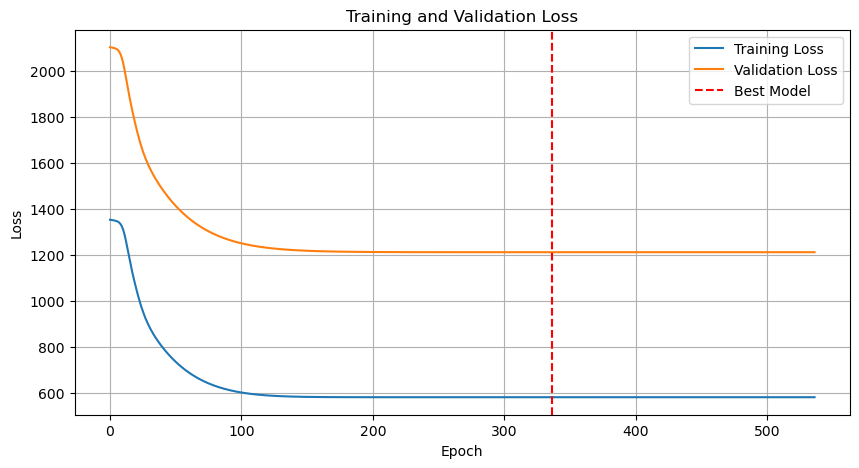

Root Mean Squared Error (RMSE): 18.0296
R²: -0.1087
Bias: 5.6444
RPD: 0.9497


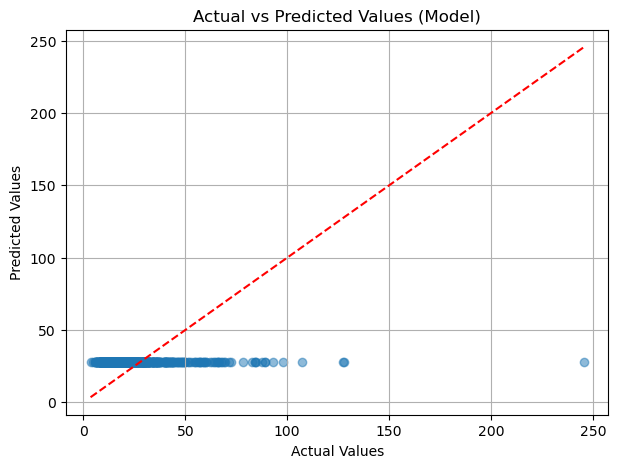

In [ ]:
# drop rate 0.2 best
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_absorb, y_train, 
                                                             test_size=0.2, 
                                                             random_state=110)

# Training enhanced LSTM model
LSTM_base_model, history, metrics = own_functions.train_and_evaluate_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test,
    hidden_size=256,
    num_layers=5,
    num_epochs=3000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2,
)



# Evaluate LSTM model
_ = own_functions.evaluate_model(LSTM_base_model, 
                             X_test=X_test_absorb, y_test=y_test, 
                             print_metrics=True, show_plot=True)

### LSTM with PLSR components

In [259]:
# Fit PLSR on the training data and transform the training set
X_train_pls = plsr_absorb_model.transform(X_train_absorb)

# Transform the test set using the fitted model (trained on the training set)
X_test_pls = plsr_absorb_model.transform(X_test_absorb)

Epoch [10/3000], Train Loss: 1476.9949, Val Loss: 1522.3971
Epoch [20/3000], Train Loss: 1298.9865, Val Loss: 1303.0087
Epoch [30/3000], Train Loss: 1055.8999, Val Loss: 1075.3479
Epoch [40/3000], Train Loss: 936.0597, Val Loss: 960.6909
Epoch [50/3000], Train Loss: 864.6968, Val Loss: 888.7760
Epoch [60/3000], Train Loss: 813.6223, Val Loss: 836.5993
Epoch [70/3000], Train Loss: 777.1158, Val Loss: 798.9126
Epoch [80/3000], Train Loss: 751.5482, Val Loss: 772.2037
Epoch [90/3000], Train Loss: 734.0804, Val Loss: 753.6362
Epoch [100/3000], Train Loss: 722.4227, Val Loss: 740.9803
Epoch [110/3000], Train Loss: 714.8896, Val Loss: 732.5262
Epoch [120/3000], Train Loss: 710.1119, Val Loss: 726.9906
Epoch [130/3000], Train Loss: 707.2158, Val Loss: 723.4321
Epoch [140/3000], Train Loss: 705.5001, Val Loss: 721.1772
Epoch [150/3000], Train Loss: 704.2849, Val Loss: 719.7388
Epoch [160/3000], Train Loss: 702.4864, Val Loss: 717.9755
Epoch [170/3000], Train Loss: 701.9086, Val Loss: 716.7893


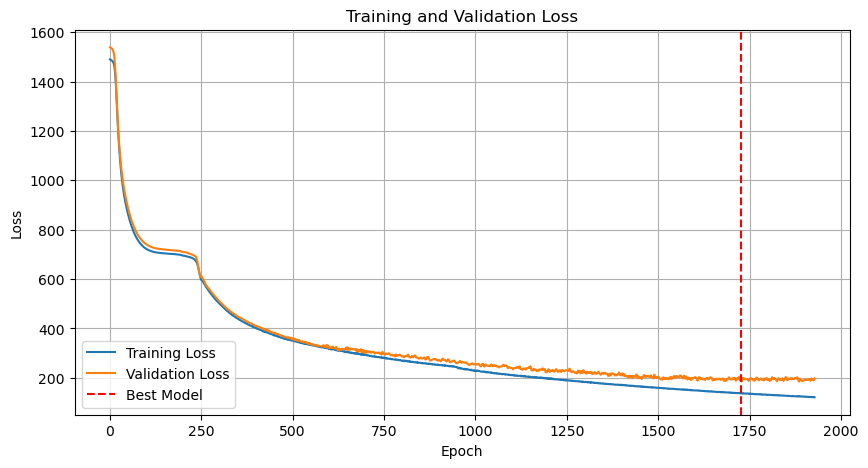

Root Mean Squared Error (RMSE): 6.2590
R²: 0.8664
Bias: -0.4263
RPD: 2.7358


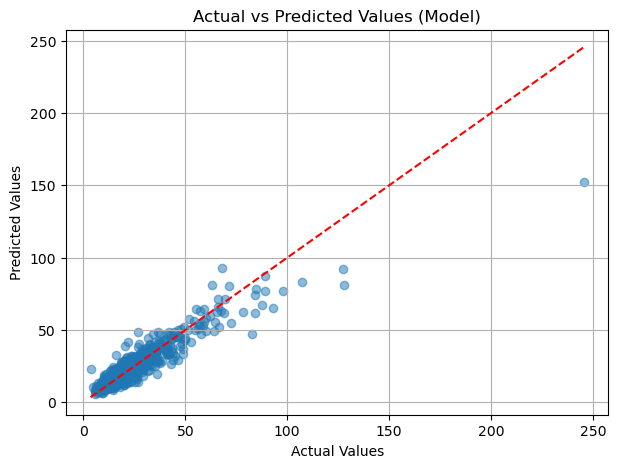

{'y_pred': array([ 17.554638 ,  29.943878 ,  71.74279  ,  23.583864 ,  24.661398 ,
         13.375087 ,  22.957867 ,  25.22774  ,  36.47243  ,  28.22427  ,
         11.682562 ,  21.11962  ,  39.35656  ,  16.566448 ,  20.577812 ,
          9.545267 ,  19.650919 ,  10.926707 ,  27.827528 ,  58.33704  ,
         16.395775 ,  19.8949   ,  10.420736 ,  53.958225 ,  17.665817 ,
         40.262455 ,  52.366566 ,  36.291523 ,  20.532324 ,  14.822706 ,
         30.73347  ,  25.535364 ,  20.031012 ,  39.080708 ,  30.449284 ,
         15.038757 ,  17.568533 ,  23.669764 ,  18.42095  ,  37.460674 ,
         10.315511 ,  15.06505  ,  12.580948 ,  32.837208 ,  31.371553 ,
         28.902525 ,  37.408573 ,  45.96419  ,  44.325974 ,  26.090849 ,
         18.375883 ,   9.875319 ,  12.033817 ,  10.879965 ,  10.189907 ,
         11.400271 ,  11.134239 ,  19.783934 ,   8.710592 ,  11.687713 ,
          8.604458 ,  10.284488 ,  11.112972 ,  14.005805 ,  15.137327 ,
         18.503912 ,  13.429158 ,  12.053

In [ ]:

# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_pls, y_train, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_plsr_model, history, metrics = own_functions.train_and_evaluate_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_pls,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test,
    hidden_size=256,
    num_layers=5,
    num_epochs=3000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2
)


lstm_plsr_eval = own_functions.evaluate_model(LSTM_plsr_model, 
                             X_test=X_test_pls, y_test=y_test, 
                             print_metrics=True, show_plot=True)

### Plsr + AutoML


In [ ]:
# Convert numpy arrays to DataFrame with wavelength columns
wavelengths = range(500, 2500, 2)  # Your wavelength range
train_df = pd.DataFrame(X_train_pls, columns=range(1, X_train_pls.shape[1] + 1))
test_df = pd.DataFrame(X_test_pls, columns=range(1, X_train_pls.shape[1] + 1))

# Add target variable
train_df['SOC'] = y_train
test_df['SOC'] = y_test

In [ ]:
# More advanced configuration with safety measures
auto_predictor = TabularPredictor(
    label='SOC',
    problem_type="regression",
    eval_metric='root_mean_squared_error',
).fit(
    train_df,
    presets='best_quality',
    num_gpus=0,
    num_cpus=1,
    memory_limit='auto',
    auto_stack=False,
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250225_124446"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.71 GB / 13.86 GB (19.6%)
Disk Space Avail:   33.10 GB / 475.69 GB (7.0%)
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "c:\Users\luis_\Desktop\Alles\Uni\Leipzig\WS_24_25\spectroscopy\final_project\soc_modelling\AutogluonModels\ag-20250225_124446"
Train Data Rows:    1964
Train Data Columns: 48
Label Column:       SOC
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2787.06 MB
	Train Data (Original)  Memory Usage: 0.72 MB (0.0% of available 

In [ ]:
print(f"predictor path is {auto_predictor.path}")
# Show leaderboard
print("\nModel Leaderboard:")
print(auto_predictor.leaderboard(test_df))

predictor path is c:\Users\luis_\Desktop\Alles\Uni\Leipzig\WS_24_25\spectroscopy\final_project\soc_modelling\AutogluonModels\ag-20250225_124446

Model Leaderboard:
                   model  score_test  score_val              eval_metric  \
0   NeuralNetFastAI_r191   -6.465653  -7.858265  root_mean_squared_error   
1    WeightedEnsemble_L2   -6.565789  -7.667403  root_mean_squared_error   
2          CatBoost_r137   -7.100844 -10.370113  root_mean_squared_error   
3               CatBoost   -7.319287  -9.634744  root_mean_squared_error   
4          CatBoost_r177   -7.464913  -9.398295  root_mean_squared_error   
5        NeuralNetFastAI   -7.833119  -8.503627  root_mean_squared_error   
6           CatBoost_r13   -8.104972  -8.996269  root_mean_squared_error   
7            CatBoost_r9   -8.638408  -9.252907  root_mean_squared_error   
8                XGBoost   -8.678744 -11.231818  root_mean_squared_error   
9            XGBoost_r33   -9.264493 -10.793384  root_mean_squared_error   


Root Mean Squared Error (RMSE): 6.5658
R²: 0.8530
Bias: -0.5860
RPD: 2.6080


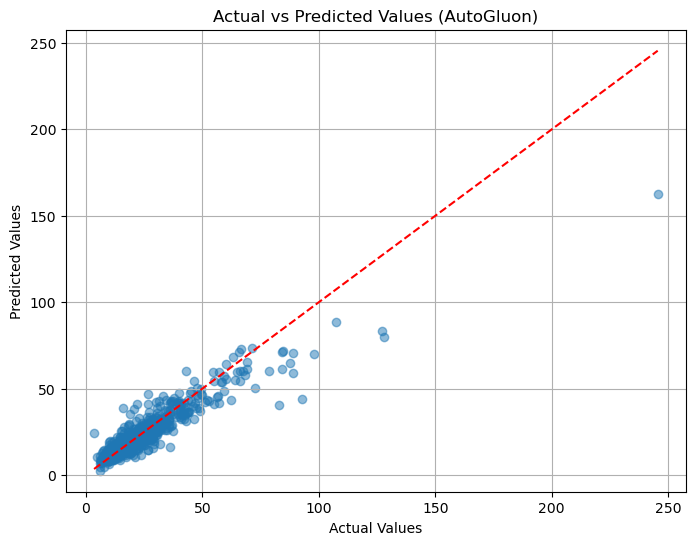

In [ ]:
# Get predictions and evaluate
y_pred_auto = auto_predictor.predict(test_df.drop(columns=['SOC']))

# Evaluate using your existing function
autogluon_eval = own_functions.evaluate_model(
    auto_predictor,
    X_test=test_df.drop(columns=['SOC']), 
    y_test=test_df['SOC'],
    print_metrics=True,
    show_plot=True,
    plot_kwargs={'model_name': 'AutoGluon', 'figsize': (8, 6)}
)

## Stragtegy 3: Testing auxiallary spectral data 

### DLR Spectral Data

https://geoservice.dlr.de/eoc/ogc/stac/v1/collections/S2-soilsuite-europe-2018-2022-P5Y

Remove Points without results. Check for MREF vs SRC.

Add parameters to training and test data of the plsr absorbance latent variables. 

In [237]:
dlr_data = gpd.read_parquet("data/auxiliary_data_results_full_updated.parquet")
# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', 100)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set width to avoid wrapping

dlr_data


,y,x,spatial_ref,time,MREF_B02,MREF_B03,MREF_B04,MREF_B05,MREF_B06,MREF_B07,MREF_B08,MREF_B8A,MREF_B11,MREF_B12,MREF-STD_B02,MREF-STD_B03,MREF-STD_B04,MREF-STD_B05,MREF-STD_B06,MREF-STD_B07,MREF-STD_B08,MREF-STD_B8A,MREF-STD_B11,MREF-STD_B12,SRC_B02,SRC_B03,SRC_B04,SRC_B05,SRC_B06,SRC_B07,SRC_B08,SRC_B8A,SRC_B11,SRC_B12,SRC-STD_B02,SRC-STD_B03,SRC-STD_B04,SRC-STD_B05,SRC-STD_B06,SRC-STD_B07,SRC-STD_B08,SRC-STD_B8A,SRC-STD_B11,SRC-STD_B12,SRC-CI95_B02,SRC-CI95_B03,SRC-CI95_B04,SRC-CI95_B05,SRC-CI95_B06,SRC-CI95_B07,SRC-CI95_B08,SRC-CI95_B8A,SRC-CI95_B11,SRC-CI95_B12,SFREQ-BSF,point_index,source_lon,source_lat,geometry
0,2548010.0,3902010.0,3035,2018-03-01,567,927,946,1516,2854,3278,3366,3560,2687,1822,139,145,236,156,336,473,477,490,336,266,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,3,4.601575,45.908022,POINT (3902010.000 2548010.000)
1,2545990.0,3908010.0,3035,2018-03-01,399,688,706,1206,2248,2535,2692,2844,2292,1373,81,107,185,166,460,532,563,557,316,294,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,0,4.680379,45.893933,POINT (3908010.000 2545990.000)
2,2555990.0,3907990.0,3035,2018-03-01,556,936,937,1369,2652,3044,3173,3361,2417,1474,148,170,226,198,457,535,582,581,336,237,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,2,4.671533,45.983716,POINT (3907990.000 2555990.000)
3,2537990.0,3899990.0,3035,2018-03-01,232,466,446,934,2171,2600,2672,2928,2098,1202,78,89,114,128,361,475,479,474,273,185,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,1,4.584692,45.816720,POINT (3899990.000 2537990.000)
4,2577990.0,3896010.0,3035,2018-03-01,431,766,805,1357,2684,3088,3312,3505,2786,1520,121,112,275,201,474,588,594,610,496,382,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,5,4.497083,46.173451,POINT (3896010.000 2577990.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2636010.0,3598010.0,3035,2018-03-01,446,753,731,1300,2789,3257,3397,3619,2506,1381,170,174,414,298,641,837,836,835,785,606,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,497,0.575760,46.423743,POINT (3598010.000 2636010.000)
2801,2869990.0,3372010.0,3035,2018-03-01,298,620,463,1110,3074,3760,3942,4199,2254,1118,139,153,284,245,532,788,804,787,529,397,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,-10000,0.000000,1671,-2.833854,48.198354,POINT (3372010.000 2869990.000)
2802,2620010.0,3788010.0,3035,2018-03-01,485,803,833,1367,2744,3216,3436,3643,2761,1578,225,238,548,400,479,639,660,652,892,684,913,1224,1724,1894,2180,2421,2582,2804,4088,2743,32,32,45,56,45,67,76,73,82,66,32,32,45,56,45,67,76,73,82,66,0.036458,2204,3.056281,46.468860,POINT (3788010.000 2620010.000)
2803,2795990.0,3357990.0,3035,2018-03-01,498,7

In [238]:
dlr_measurements = ["MREF_B02", "MREF_B03", "MREF_B04", "MREF_B05", "MREF_B06", "MREF_B07", "MREF_B08", "MREF_B8A", "MREF_B11", "MREF_B12",  # Mean Reflectance bands
                        "MREF-STD_B02", "MREF-STD_B03", "MREF-STD_B04", "MREF-STD_B05", "MREF-STD_B06", "MREF-STD_B07", "MREF-STD_B08", "MREF-STD_B8A", "MREF-STD_B11", "MREF-STD_B12",  # Standard deviation bands
                        # "SRC_B02", "SRC_B03", "SRC_B04", "SRC_B05", "SRC_B06", "SRC_B07", "SRC_B08", "SRC_B8A", "SRC_B11", "SRC_B12",  # Bare Surface Reflectance bands
                        # "SRC-STD_B02", "SRC-STD_B03", "SRC-STD_B04", "SRC-STD_B05", "SRC-STD_B06", "SRC-STD_B07", "SRC-STD_B08", "SRC-STD_B8A", "SRC-STD_B11", "SRC-STD_B12",  # Bare Surface Standard Deviation bands
                        # "SRC-CI95_B02", "SRC-CI95_B03", "SRC-CI95_B04", "SRC-CI95_B05", "SRC-CI95_B06", "SRC-CI95_B07", "SRC-CI95_B08", "SRC-CI95_B8A", "SRC-CI95_B11", "SRC-CI95_B12",  # Bare Surface 95% Confidence Interval bands
                        # "SFREQ-BSF" #, "SFREQ-BSC", "SFREQ-VPC"
                        ]

In [ ]:
original_ks_indices = ks_indices
original_test_indices = test_indices

In [ ]:
# Create a mapping from original indices to rows in the auxiliary data
point_to_row = dict(zip(dlr_data['point_index'], dlr_data.index))

# Filter indices to only include those with data in dlr_data
valid_ks_indices = [idx for idx in original_ks_indices if idx in point_to_row]
valid_test_indices = [idx for idx in original_test_indices if idx in point_to_row]

# Map original indices to row positions in dlr_data
mapped_ks_indices = [point_to_row[idx] for idx in valid_ks_indices]
mapped_test_indices = [point_to_row[idx] for idx in valid_test_indices]

# Now use these mapped indices to select data
dlr_train_ks = dlr_data.iloc[mapped_ks_indices]
dlr_test_ks = dlr_data.iloc[mapped_test_indices]

# Calculate indices
indices_train_ks = own_functions.compute_indices(dlr_train_ks)
indices_test_ks = own_functions.compute_indices(dlr_test_ks)

# Combine indices with original data
dlr_train_ks = pd.concat([dlr_train_ks[dlr_measurements], indices_train_ks], axis=1)
dlr_test_ks = pd.concat([dlr_test_ks[dlr_measurements], indices_test_ks], axis=1)

# Print shapes
print(f"Original indices: {len(original_ks_indices)} training, {len(original_test_indices)} test")
print(f"Valid indices with aux data: {len(valid_ks_indices)} training, {len(valid_test_indices)} test")

Original indices: 1964 training, 843 test
Valid indices with aux data: 1962 training, 843 test


In [246]:
# # select only relevant columns
# dlr_train_ks = dlr_train_ks[dlr_measurements].values
# dlr_test_ks = dlr_test_ks[dlr_measurements].values
dlr_train_ks = dlr_train_ks.values
dlr_test_ks = dlr_test_ks.values

# Print number of rows containing NaN values
print(f"NaN values in DLR Train data: {np.isnan(dlr_train_ks).sum()}")

dlr_train_ks = np.nan_to_num(dlr_train_ks, nan=0, posinf=0, neginf=0)
dlr_test_ks = np.nan_to_num(dlr_test_ks, nan=0, posinf=0, neginf=0)

print(f"Auxillary DLR Train data shape: {dlr_train_ks.shape}")
print(f"Auxillary DLR Test data shape: {dlr_test_ks.shape}")

NaN values in DLR Train data: 48
Auxillary DLR Train data shape: (1962, 38)
Auxillary DLR Test data shape: (843, 38)


In [247]:
# Map from original index to position in X_train_absprb
original_to_train_pos = {orig_idx: train_pos for train_pos, orig_idx in enumerate(ks_indices)}

# Find the positions in X_train_absprb that correspond to valid_ks_indices
train_absprb_positions = []
for idx in valid_ks_indices:
    if idx in original_to_train_pos:
        train_absprb_positions.append(original_to_train_pos[idx])

# Now use these positions to select from X_train_absprb
X_train_absprb_dlr = X_train_absorb[train_absprb_positions, :]
y_train_dlr = y_train[train_absprb_positions]

# Do the same for test data
original_to_test_pos = {orig_idx: test_pos for test_pos, orig_idx in enumerate(test_indices)}

test_absprb_positions = []
for idx in valid_test_indices:
    if idx in original_to_test_pos:
        test_absprb_positions.append(original_to_test_pos[idx])

X_test_absprb_dlr = X_test_absorb[test_absprb_positions, :]
y_test_dlr = y_test[test_absprb_positions]

# Print shapes
print(f"X_train_absorb_dlr shape: {X_train_absprb_dlr.shape}")
print(f"X_test_absprb_dlr shape: {X_test_absprb_dlr.shape}")
print(f"y_train_dlr shape: {y_train_dlr.shape}")
print(f"y_test_dlr shape: {y_test_dlr.shape}")

X_train_absorb_dlr shape: (1962, 1000)
X_test_absprb_dlr shape: (843, 1000)
y_train_dlr shape: (1962,)
y_test_dlr shape: (843,)


In [248]:
# Add the auxiliary data to the PLSR transformed data
X_train_combined = np.hstack((X_train_absprb_dlr, dlr_train_ks))
X_test_combined = np.hstack((X_test_absprb_dlr, dlr_test_ks))

# Print shapes
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

X_train_combined shape: (1962, 1038)
X_test_combined shape: (843, 1038)


Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

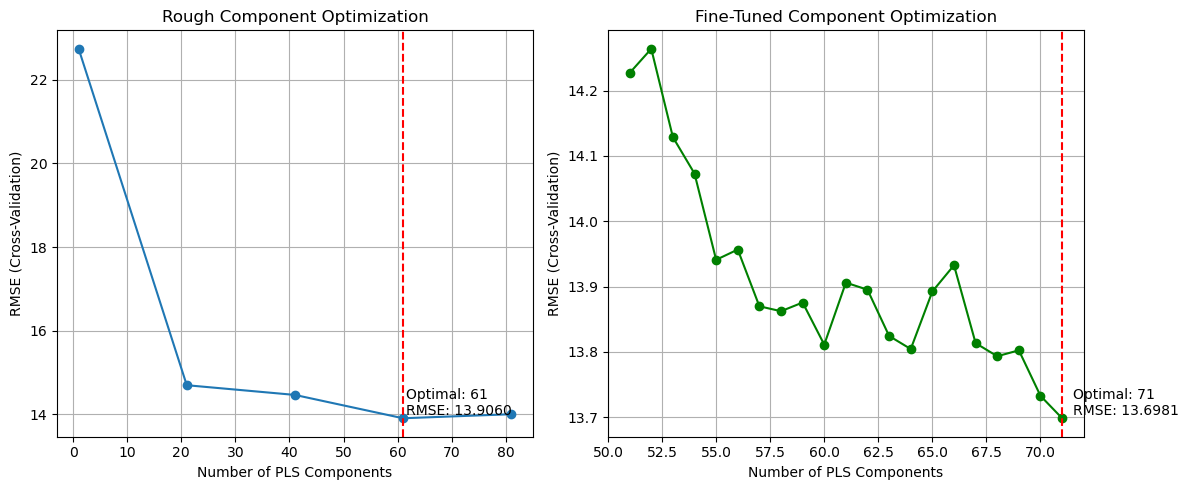

Root Mean Squared Error (RMSE): 8.9545
R²: 0.7265
Bias: 0.2841
RPD: 1.9123


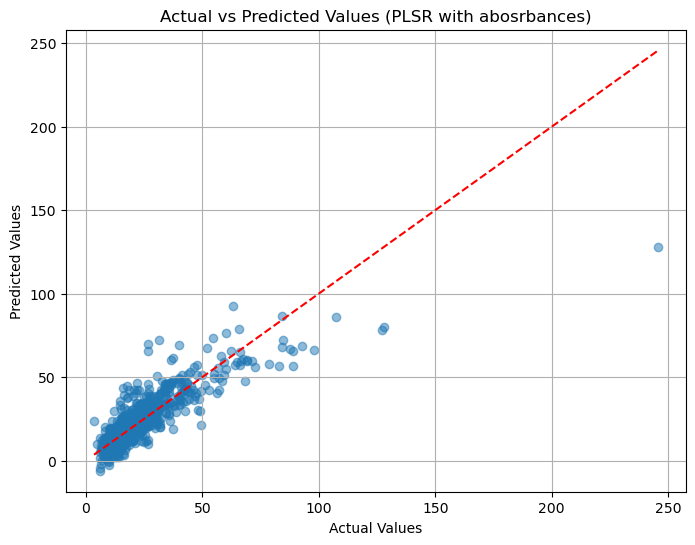

In [249]:
plsr_dlr_components = own_functions.optimize_pls_components(X_train=X_train_combined, 
                                      y_train=y_train_dlr,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )


plsr_absorb_dlr_model = PLSRegression(plsr_dlr_components["optimal_n"])
plsr_absorb_dlr_model.fit(X_train_combined, y_train_dlr)

plsr_absorb_dlr_eval = own_functions.evaluate_model(plsr_absorb_dlr_model,
                             X_test=X_test_combined,
                             y_test=y_test_dlr,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with abosrbances',
                             'figsize': (8, 6)}
                             )

In [250]:
# transform the data using plsr_absorb_dlr_model
X_train_plsr_absorb_dlr = plsr_absorb_dlr_model.transform(X_train_combined)
X_test_plsr_absorb_dlr = plsr_absorb_dlr_model.transform(X_test_combined)

Epoch [10/3000], Train Loss: 1540.5464, Val Loss: 1257.4043
Epoch [20/3000], Train Loss: 1344.9900, Val Loss: 1036.0135
Epoch [30/3000], Train Loss: 1098.5538, Val Loss: 813.5641
Epoch [40/3000], Train Loss: 986.3824, Val Loss: 711.8333
Epoch [50/3000], Train Loss: 917.4670, Val Loss: 647.8571
Epoch [60/3000], Train Loss: 866.9979, Val Loss: 601.1006
Epoch [70/3000], Train Loss: 830.6962, Val Loss: 567.8345
Epoch [80/3000], Train Loss: 805.1898, Val Loss: 544.7816
Epoch [90/3000], Train Loss: 787.6553, Val Loss: 529.2339
Epoch [100/3000], Train Loss: 775.8893, Val Loss: 519.0675
Epoch [110/3000], Train Loss: 768.2424, Val Loss: 512.6531
Epoch [120/3000], Train Loss: 763.3832, Val Loss: 508.7702
Epoch [130/3000], Train Loss: 760.3764, Val Loss: 506.5227
Epoch [140/3000], Train Loss: 758.4575, Val Loss: 505.1368
Epoch [150/3000], Train Loss: 757.2153, Val Loss: 503.8857
Epoch [160/3000], Train Loss: 755.8500, Val Loss: 499.4169
Epoch [170/3000], Train Loss: 753.3842, Val Loss: 498.8031
E

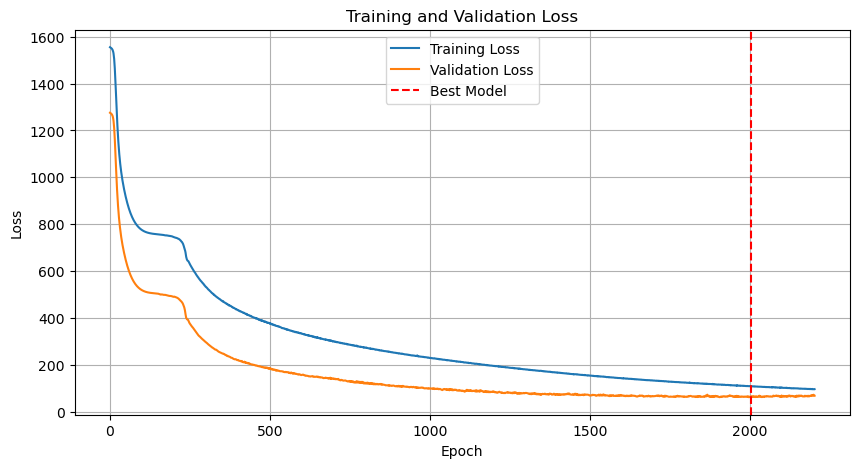

Root Mean Squared Error (RMSE): 6.0841
R²: 0.8738
Bias: -0.3307
RPD: 2.8144


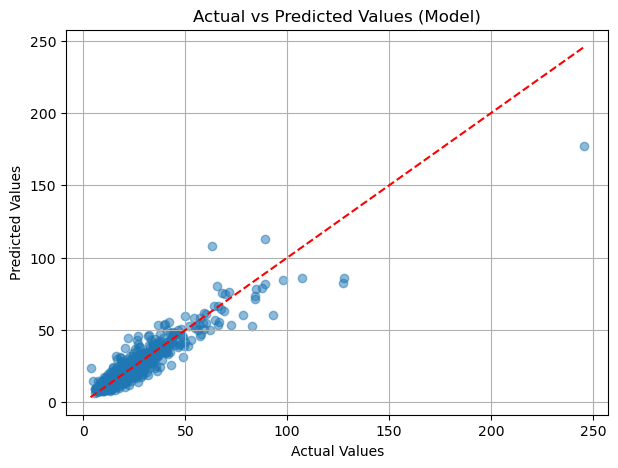

In [251]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_plsr_absorb_dlr, y_train_dlr, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_plsr_dlr_model, history, metrics = own_functions.train_and_evaluate_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_plsr_absorb_dlr,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_dlr,
    hidden_size=256,
    num_layers=5,
    num_epochs=3000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2
)


lstm_plsr_eval = own_functions.evaluate_model(LSTM_plsr_dlr_model, 
                             X_test=X_test_plsr_absorb_dlr, y_test=y_test_dlr, 
                             print_metrics=True, show_plot=True)

### ISRIC Soil Data
https://www.isric.org/explore/soilgrids


In [109]:
# read pd from csv
isric_data = pd.read_csv('data/soilgrids_parallel.csv')
isric_data.head()

,point_index,lon,lat,bdod_0_to_5cm_mean,bdod_5_to_15cm_mean,bdod_15_to_30cm_mean,clay_0_to_5cm_mean,clay_5_to_15cm_mean,clay_15_to_30cm_mean,phh2o_0_to_5cm_mean,...,sand_0_to_5cm_mean,sand_5_to_15cm_mean,sand_15_to_30cm_mean,silt_0_to_5cm_mean,silt_5_to_15cm_mean,silt_15_to_30cm_mean,soc_0_to_5cm_mean,soc_5_to_15cm_mean,soc_15_to_30cm_mean,error
0,1,4.584692,45.816720,125.0,134.0,141.0,250.0,270.0,302.0,58.0,...,375.0,366.0,366.0,375.0,364.0,332.0,489.0,249.0,246.0,NaN
1,0,4.680379,45.893933,128.0,138.0,141.0,303.0,319.0,338.0,62.0,...,263.0,243.0,275.0,434.0,438.0,387.0,467.0,254.0,182.0,NaN
2,3,4.601575,45.908022,133.0,140.0,144.0,247.0,268.0,288.0,60.0,...,334.0,320.0,329.0,418.0,412.0,383.0,401.0,289.0,153.0,NaN
3,2,4.671533,45.983716,129.0,139.0,143.0,249.0,254.0,300.0,63.0,...,305.0,295.0,313.0,446.0,451.0,387.0,422.0,271.0,154.0,NaN
4,6,4.439863,46.224665,102.0,116.0,121.0,188.0,172.0,205.0,52.0,...,505.0,514.0,494.0,306.0,314.0,301.0,786.0,620.0,239.0,NaN


In [278]:
# check if any lon is 88.8888 and lat is 88.8888
isric_data[isric_data['lon'].isin([88.888888])]

,point_index,lon,lat,bdod_0_to_5cm_mean,bdod_5_to_15cm_mean,bdod_15_to_30cm_mean,clay_0_to_5cm_mean,clay_5_to_15cm_mean,clay_15_to_30cm_mean,phh2o_0_to_5cm_mean,phh2o_5_to_15cm_mean,phh2o_15_to_30cm_mean,sand_0_to_5cm_mean,sand_5_to_15cm_mean,sand_15_to_30cm_mean,silt_0_to_5cm_mean,silt_5_to_15cm_mean,silt_15_to_30cm_mean,soc_0_to_5cm_mean,soc_5_to_15cm_mean,soc_15_to_30cm_mean,error
511,513,88.888888,88.888888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
933,935,88.888888,88.888888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
isric_measurements = ["bdod_0_to_5cm_mean", "bdod_5_to_15cm_mean", "bdod_15_to_30cm_mean", 
                      "clay_0_to_5cm_mean", "clay_5_to_15cm_mean", "clay_15_to_30cm_mean", 
                      "phh2o_0_to_5cm_mean", "phh2o_5_to_15cm_mean", "phh2o_15_to_30cm_mean",
                      "sand_0_to_5cm_mean", "sand_5_to_15cm_mean", "sand_15_to_30cm_mean",
                      "silt_0_to_5cm_mean", "silt_5_to_15cm_mean", "silt_15_to_30cm_mean"]

In [ ]:
# Create a mapping from original indices to rows in the isriciliary data
point_to_row = dict(zip(isric_data['point_index'], isric_data.index))

# Filter indices to only include those with data in isric_data
valid_ks_indices = [idx for idx in original_ks_indices if idx in point_to_row]
valid_test_indices = [idx for idx in original_ks_indices if idx in point_to_row]

# Map original indices to row positions in isric_data
mapped_ks_indices = [point_to_row[idx] for idx in valid_ks_indices]
mapped_test_indices = [point_to_row[idx] for idx in valid_test_indices]

# Now use these mapped indices to select data
isric_train_ks = isric_data.iloc[mapped_ks_indices]
isric_test_ks = isric_data.iloc[mapped_test_indices]

# Print shapes
print(f"Original indices: {len(ks_indices)} training, {len(test_indices)} test")
print(f"Valid indices with isric data: {len(valid_ks_indices)} training, {len(valid_test_indices)} test")

# select only relevant columns
isric_train_ks = isric_train_ks[isric_measurements].values
isric_test_ks = isric_test_ks[isric_measurements].values

isric_train_ks = np.nan_to_num(isric_train_ks, nan=0, posinf=0, neginf=0)
isric_test_ks = np.nan_to_num(isric_test_ks, nan=0, posinf=0, neginf=0)

print(f"Auxillary isric Train data shape: {isric_train_ks.shape}")
print(f"Auxillary isric Test data shape: {isric_test_ks.shape}")

Original indices: 1964 training, 843 test
Valid indices with isric data: 1964 training, 843 test
Auxillary isric Train data shape: (1964, 15)
Auxillary isric Test data shape: (843, 15)


In [ ]:
original_train_indices = ks_indices  # These are the indices used to create X_train_pls

# Map from original index to position in X_train_pls
original_to_train_pos = {orig_idx: train_pos for train_pos, orig_idx in enumerate(original_train_indices)}

# Find the positions in X_train_pls that correspond to valid_ks_indices
train_pls_positions = []
for idx in valid_ks_indices:
    if idx in original_to_train_pos:
        train_pls_positions.append(original_to_train_pos[idx])

# Now use these positions to select from X_train_pls
X_train_pls_isric = X_train_absorb[train_pls_positions, :]
y_train_isric = y_train[train_pls_positions]

# Do the same for test data
original_test_indices = test_indices  # These are the indices used to create X_test_pls
original_to_test_pos = {orig_idx: test_pos for test_pos, orig_idx in enumerate(original_test_indices)}

test_pls_positions = []
for idx in valid_test_indices:
    if idx in original_to_test_pos:
        test_pls_positions.append(original_to_test_pos[idx])

X_test_pls_isric = X_test_absorb[test_pls_positions, :]
y_test_isric = y_test[test_pls_positions]

# Print shapes
print(f"X_train_pls_isric shape: {X_train_pls_isric.shape}")
print(f"X_test_pls_isric shape: {X_test_pls_isric.shape}")
print(f"y_train_isric shape: {y_train_isric.shape}")
print(f"y_test_isric shape: {y_test_isric.shape}")

# Add the isriciliary data to the PLSR transformed data
X_train_combined = np.hstack((X_train_pls_isric, isric_train_ks))
X_test_combined = np.hstack((X_test_pls_isric, isric_test_ks))

# standardize the data
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# Print shapes
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

X_train_pls_isric shape: (1964, 1000)
X_test_pls_isric shape: (843, 1000)
y_train_isric shape: (1964,)
y_test_isric shape: (843,)
X_train_combined shape: (1964, 1015)
X_test_combined shape: (843, 1015)


Rough Optimization:   0%|          | 0/5 [00:00<?, ?it/s]

Fine Tuning:   0%|          | 0/21 [00:00<?, ?it/s]

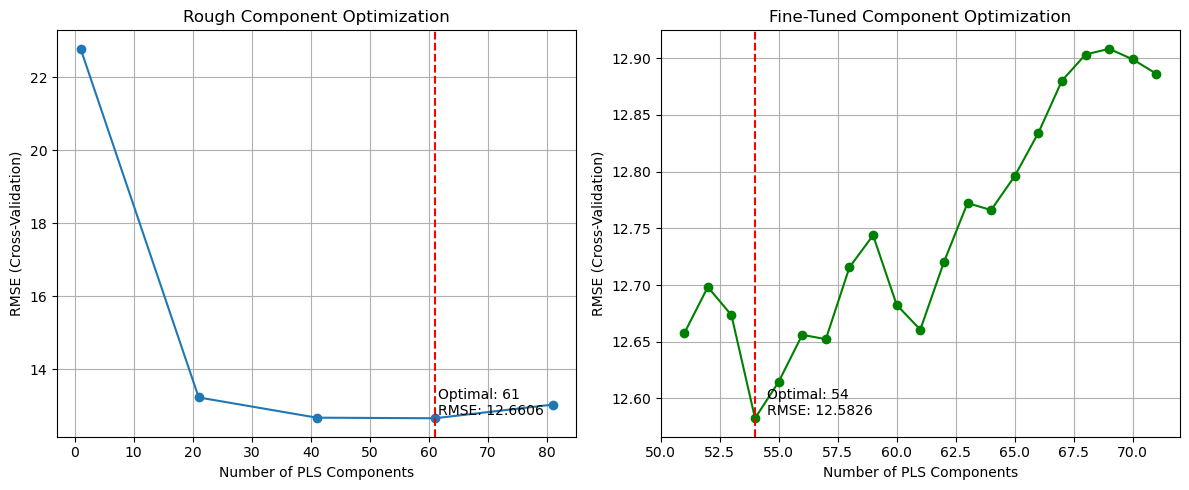

Root Mean Squared Error (RMSE): 8.7390
R²: 0.7395
Bias: 0.7804
RPD: 1.9594


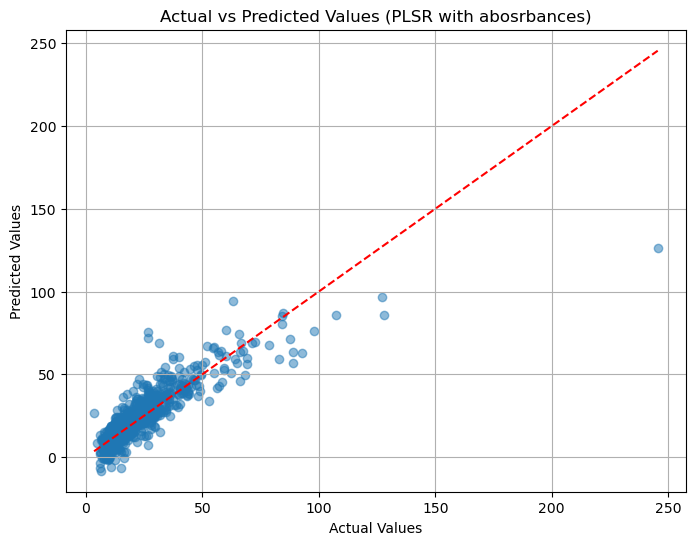

In [130]:
plsr_isric_components = own_functions.optimize_pls_components(X_train=X_train_combined, 
                                      y_train=y_train_isric,
                                      max_components=100,
                                      step=20,
                                      fine_tune=True,
                                      show_progress=True,
                                      plot_results=True
                                      )


plsr_absorb_aux_model = PLSRegression(n_components=plsr_isric_components["optimal_n"])
plsr_absorb_aux_model.fit(X_train_combined, y_train_isric)

plsr_absorb_aux_eval = own_functions.evaluate_model(plsr_absorb_aux_model,
                             X_test=X_test_combined,
                             y_test=y_test_isric,
                             print_metrics=True,
                             show_plot=True,
                             plot_kwargs={'model_name': 'PLSR with abosrbances',
                             'figsize': (8, 6)}
                             )

In [ ]:
X_train_comb_plsr = plsr_absorb_aux_model.transform(X_train_combined)
X_test_comb_plsr = plsr_absorb_aux_model.transform(X_test_combined)

In [ ]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_comb_plsr, y_train_isric, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_aux_model, history, metrics = own_functions.train_and_evaluate_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_comb_plsr,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_isric,
    hidden_size=256,
    num_layers=5,
    num_epochs=4000,
    learning_rate=0.001,
    patience=300,  # Early stopping patience
    dropout=0.2
)


lstm_eval = own_functions.evaluate_model(LSTM_aux_model, 
                             X_test=X_test_comb_plsr, y_test=y_test_isric, 
                             print_metrics=True, show_plot=True)

Epoch [10/4000], Train Loss: 1475.2972, Val Loss: 1519.5110
Epoch [20/4000], Train Loss: 1280.4115, Val Loss: 1283.1000
Epoch [30/4000], Train Loss: 1040.9993, Val Loss: 1062.2501
Epoch [40/4000], Train Loss: 929.5973, Val Loss: 954.4364
Epoch [50/4000], Train Loss: 861.1890, Val Loss: 885.2343
Epoch [60/4000], Train Loss: 811.6935, Val Loss: 834.5779
Epoch [70/4000], Train Loss: 775.9415, Val Loss: 797.5146
Epoch [80/4000], Train Loss: 750.5928, Val Loss: 770.7653
Epoch [90/4000], Train Loss: 732.1863, Val Loss: 751.7930
Epoch [100/4000], Train Loss: 718.9263, Val Loss: 738.2095
Epoch [110/4000], Train Loss: 709.2322, Val Loss: 727.8226
Epoch [120/4000], Train Loss: 702.1847, Val Loss: 720.2368
Epoch [130/4000], Train Loss: 696.5098, Val Loss: 714.1851
Epoch [140/4000], Train Loss: 691.6286, Val Loss: 708.9233
Epoch [150/4000], Train Loss: 686.7952, Val Loss: 703.0333
Epoch [160/4000], Train Loss: 676.5783, Val Loss: 696.5714
Epoch [170/4000], Train Loss: 660.6702, Val Loss: 671.7918


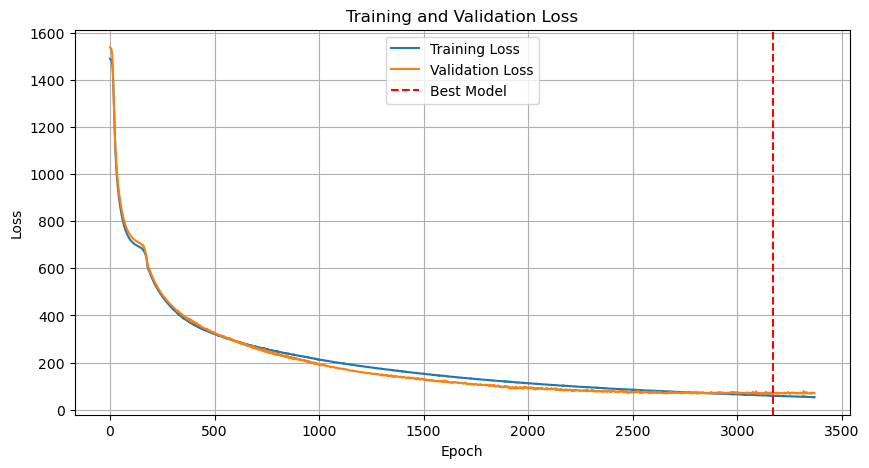

Root Mean Squared Error (RMSE): 5.7093
R²: 0.8888
Bias: -0.2987
RPD: 2.9992


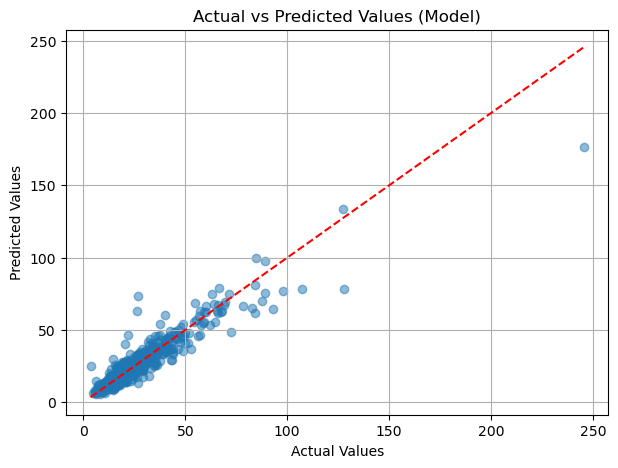

In [132]:
# First split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_comb_plsr, y_train_isric, 
                                                             test_size=0.2, 
                                                             random_state=42)

# Training enhanced LSTM model
LSTM_aux_model, history, metrics = own_functions.train_and_evaluate_lstm(
    X_train=X_train_final,
    X_val=X_val,
    X_test=X_test_comb_plsr,
    y_train=y_train_final,
    y_val=y_val,
    y_test=y_test_isric,
    hidden_size=256,
    num_layers=5,
    num_epochs=4000,
    learning_rate=0.001,
    patience=200,  # Early stopping patience
    dropout=0.2
)


lstm_eval = own_functions.evaluate_model(LSTM_aux_model, 
                             X_test=X_test_comb_plsr, y_test=y_test_isric, 
                             print_metrics=True, show_plot=True)

#### Test base lstm+plsr with lower samples

In [268]:
max(mapped_test_indices)

2801

In [267]:
X_test_test = X_test_pls[mapped_test_indices, :]

IndexError: index 844 is out of bounds for axis 0 with size 843

In [ ]:
X_test_test.shape

(843, 48)

In [ ]:
lstm_plsr_eval = own_functions.evaluate_model(LSTM_plsr_model, 
                             X_test=X_test_pls, y_test=y_test, 
                             print_metrics=True, show_plot=True)

# Discussion of Results (5 P):
- Briefly discuss your results and interpret them based on the validation metrics for the
test set. 
- Compare your findings with those of published studies in a similar context.
- Evaluate whether soil VNIR reflectance spectroscopy could serve as a complementary
approach for large-scale soil organic carbon assessment in Earth (system) science.

**Additional Information:**

The length of the discussion section really depends on your results, but as a general guideline, I would expect it to be around one page.

- **Focus on**: 
  - directly comparing your different modeling approaches 
  - interpreting which performed best based on the validation metrics
- If the results are not as good as expected:
  - consider discussing possible reasons and suggesting ways to improve them 
  - (you might find 1-2 examples from the literature helpful here).

- Additionally, you could compare your findings with similar studies that have attempted to model SOC (or related properties) at national or continental scales using spectroscopy—ideally referencing 2-3 relevant publications.

- Finally, reflect on whether and how soil VNIR spectroscopy could contribute to large-scale soil information systems. 
  - This is a more theoretical aspect, and you are free in how you approach this point. 
  - Important aspects to consider might include:
    - a) Model accuracy (What would be considered a good accuracy in this context?)
    - b) Data harmonization (Challenges when combining datasets from different providers)
    - c) Practical usability (Would end users require programming skills, etc.?)

A recent publication that could provide a useful overview is:
Peng et al. (2025): Spectroscopic solutions for generating new global soil information
(Link: https://www.sciencedirect.com/science/article/pii/S2666675825000426)"